# IMAGE CAPTIONING

Rishabh Jha

S201900010150

**DATASET**

FLICKR 8k dataset used. 7K for training and 1k remaining for testing out the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


**Importing the Necessary Libraries**

In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [ ]:
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img,img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler

**DATA PREPROCESSING**

In [ ]:
filename = "/content/drive/MyDrive/Image Captioning/Flickr8k_text/Flickr8k.token.txt" # Absolute path of the caption 
file = open(filename,'r')
doc = file.read() # This will contain the Caption of the each image in a textual format

print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [ ]:
# Loading the Caption with the Image name as a id to the dictionary : dict[image_name] = captions

descriptions =dict()
for line in doc.split('\n'):# splitting the doc using newline

  if len(line)<2:
    continue
  tokens =  line.split() #splitting the line by white spaces

  image_id , image_desc = tokens[0],tokens[1:]
  image_desc = ' '.join(image_desc) # joining the generated words by splitting into again captions

  # image id -> 1000268201_693b08cb0e.jpg#0 we have to split it by dot to get unique name of image
  image_name = image_id.split('.')[0]

  if image_name not in descriptions.keys():
    descriptions[image_name] = list()
  
  descriptions[image_name].append(image_desc)

print(len(descriptions))

8092


In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

**Removing the Punctuations , numerics, and all the single length words and Finally lowering all the letters**

In [ ]:
table = str.maketrans('','',string.punctuation)

for _, captions in descriptions.items():
  for i in range(len(captions)):

    desc = captions[i].split()

    # removing punctuations
    desc = [c.translate(table) for c in desc]

    # removing non alphabetic characters
    desc = [word for word in desc if word.isalpha()]

    # removing single length words
    desc = [word for word in desc if len(word)>=2]

    # converting all the char into lower 
    desc = [word.lower() for word in desc]

    captions[i] = ' '.join(desc)

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Making the Vocabolary i.e. Set of all the word present**

In [ ]:
vocabulary = set()

for key in descriptions:
  for d in descriptions[key]:
    vocabulary.update(d.split())

print('Vocabulary Size :',len(vocabulary))

Vocabulary Size : 8763


**Using both training and Validation set for training and test set for testing**

In [ ]:
filename1 = "/content/drive/MyDrive/Image Captioning/Flickr8k_text/Flickr_8k.trainImages.txt" # Captions for training dataset
file = open(filename1,'r')
train_doc = file.read()

training_image_name = list()

for line in train_doc.split('\n'):
  if len(line)<1:
    continue
  
  id = line.split('.')[0]
  training_image_name.append(id) # training_image_name will contain the name of images without the .jpg extension

filename2 = "/content/drive/MyDrive/Image Captioning/Flickr8k_text/Flickr_8k.devImages.txt" # Captions for training dataset
file = open(filename2,'r')
val_doc = file.read()

for line in val_doc.split('\n'):
  if len(line)<1:
    continue
  
  id = line.split('.')[0]
  training_image_name.append(id)


training_image_name = set(training_image_name)
print('Length of Train Datset:',len(training_image_name))
print(training_image_name)

Length of Train Datset: 7000
{'119534510_d52b3781a3', '3210457502_c6030ce567', '3388836914_c267cf3a59', '2976350388_3984e3193d', '378170167_9b5119d918', '2088910854_c6f8d4f5f9', '408627152_1feaa4b94e', '3069216757_c419b3898e', '3360994630_d4616c1b14', '534200447_b0f3ff02be', '2272823323_3b7291cd47', '782401952_5bc5d3413a', '421153376_d1d325568f', '3217909454_7baa0edbb2', '2873188959_ff023defa9', '2056042552_f59e338533', '174466741_329a52b2fe', '2883950737_3b67d24af4', '818340833_7b963c0ee3', '2872743471_30e0d1a90a', '3324746155_71e14f60ce', '782017931_75d92bb7a4', '522486784_978021d537', '2192411521_9c7e488c5e', '3674168459_6245f4f658', '3111502208_71e2a414f5', '229951087_4c20600c32', '3538686658_30afc75f02', '289860281_94d699f36d', '944374205_fd3e69bfca', '111537217_082a4ba060', '2149968397_a7411729d1', '3077781040_bc27778609', '2102724238_3cf921d7bb', '302241178_a582c1b953', '2108799322_e25aa6e185', '3650111717_346804ec2f', '3208553539_2bf6c6d162', '578644583_da3ff18dd1', '2675190069

In [ ]:
images = '/content/drive/MyDrive/Image Captioning/Flicker8k_Dataset/'
img = glob.glob(images+'*.jpg') # storing the full image path inside the img variable

print(img[0])

/content/drive/MyDrive/Image Captioning/Flicker8k_Dataset/381976882_0063d16d88.jpg


**Making List containg the full image path of Training Images (Train + Val)**

In [ ]:
training_image_file  = set(open(filename1, 'r').read().strip().split('\n')) # image_name.jpg

# Create a list of all the training images with their full path names
training_image_full_path = [] # /content/drive/MyDrive/Image Captioning/Flicker8k_Dataset/image_name.jpg

for i in img: # img is list of full path names of all images
    if i[len(images):] in training_image_file: # Check if the image belongs to training set
        training_image_full_path.append(i) # Add it to the list of train images

training_image_file2  = set(open(filename2, 'r').read().strip().split('\n')) # image_name.jpg
for i in img: # img is list of full path names of all images
    if i[len(images):] in training_image_file2: # Check if the image belongs to training set
        training_image_full_path.append(i) # Add it to the list of train images

In [ ]:
print(len(training_image_full_path))
print(training_image_full_path[0])

7000
/content/drive/MyDrive/Image Captioning/Flicker8k_Dataset/381976882_0063d16d88.jpg


**Making List containg the full image path of Testing Images**

In [ ]:
test_images_file = '/content/drive/MyDrive/Image Captioning/Flickr8k_text/Flickr_8k.testImages.txt'

test_image_file = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_image_full_path = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_image_file: # Check if the image belongs to test set
        test_image_full_path.append(i) # Add it to the list of test images

In [ ]:
print(len(test_image_full_path))
print(test_image_full_path[0])

1000
/content/drive/MyDrive/Image Captioning/Flicker8k_Dataset/384577800_fc325af410.jpg


**Making the Dictionary to store the list of captions related to train images**

In [ ]:
train_desc = dict()

for i in descriptions.keys():
  if i in training_image_name:
    if i not in train_desc:
      train_desc[i] = list()  # train_desc [key] = list of captions related to key.jpg image file

    for cap in descriptions[i]:
      desc = 'startseq '+cap+' endseq'
      train_desc[i].append(desc)

print(len(train_desc))

7000


In [ ]:
train_desc['2254913901_569f568926']

['startseq louis vuitton store window at night endseq',
 'startseq woman looks at clothes in louis vuitton store window endseq',
 'startseq woman widow shops outside of louis vuitton store endseq',
 'startseq the woman in black is looking at outfits in clothing store window endseq',
 'startseq woman on the street window shops in front of the store louis vuitton endseq']

**Using InceptionV3 CNN model to extract the feature vector of input images**

In [ ]:
model = InceptionV3(weights='imagenet') # loading the inceptionv3 model
new_model = Model (model.input, model.layers[-2].output) # creating a new_model which have same input but second last layer as an output

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
def preprocess(path):
  img_ = load_img(path,target_size=(299,299)) # reshaping the input images into 299x299 same as inceptionv3
  x_arr = img_to_array(img_) # converting the image into 3d array
  x_arr = np.expand_dims(x_arr,axis=0) # adding a new dimension => (299,299,3) will converted into (1,299,299,3)
  x_arr = preprocess_input(x_arr)

  return x_arr                      

In [ ]:
def encode(path):
    image = preprocess(path) # preprocess the image
    feat_vec = new_model.predict(image) # Get the encoding vector for the image
    feat_vec = np.reshape(feat_vec, feat_vec.shape[1]) # reshape from (1, 2048) to (2048, )

    return feat_vec

In [ ]:
# Storing the feature vector of training images so that they can be used further later when needed without being calculated

encoding_train_image = {}
i=1
for img_ in training_image_full_path:
    encoding_train_image[img_[len(images):]] = encode(img_)
    if i%500==0:
      print(i)
    i+=1 

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [ ]:
#Storing in the pickle file
with open("/content/drive/MyDrive/Image Captioning/Resources/encoded_train_images_with_val.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train_image, encoded_pickle)

In [ ]:
#Importing the feature 
train_features = load(open("/content/drive/MyDrive/Image Captioning/Resources/encoded_train_images_with_val.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=7000


In [ ]:
# Storing the feature vector of testing images so that they can be used further later when needed without being calculated
encoding_test_image = {}
i=1
for img_ in test_image_full_path:
    encoding_test_image[img_[len(images):]] = encode(img_)
    if i%500==0:
      print(i)
    i+=1

In [ ]:
#Storing in the pickle file
with open("/content/drive/MyDrive/Image Captioning/Resources/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test_image, encoded_pickle)

In [ ]:
#Importing the feature 
test_features = load(open("/content/drive/MyDrive/Image Captioning/Resources/encoded_test_images.pkl", "rb"))
print('Photos: test=%d' % len(test_features))

Photos: test=1000


**Storing all the training captions in a list**

In [ ]:
all_train_captions = []
for key in train_desc.keys():
    for cap in train_desc[key]:
        all_train_captions.append(cap)
len(all_train_captions)

35000

In [ ]:
str_all_train_captions = str(all_train_captions).replace(',',' ').replace('\'',' ')

**Removing all the words from the vocabulary which are coming less than 8 times because we want our model to focus more on the relevant words**

In [ ]:
# considering all those words which appear more than or equal to 8 times in our training corpus

word_count_threshold = 8
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab_ = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab_)))

preprocessed words 8169 -> 2075


In [ ]:
vocab_[:5]

['startseq', 'child', 'in', 'pink', 'dress']

**Making dictionary in order to help to convert the captions into sequence of numbers**

In [ ]:
ixtoword = {} # will give word as an output for an index ( from 1 to 1889)
wordtoix = {} # will give an index as an output for a word

ix = 1
for w in vocab_:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
vocab_size = len(ixtoword) + 1 # one for appended 0's after padding 
vocab_size

2076

**Calculating the Maximum caption length**

In [ ]:
all_desc = list()
for key in train_desc.keys():
  [all_desc.append(d) for d in train_desc[key]]

max_length = max(len(d.split()) for d in all_desc)
print(max_length)

34


**WORD EMBEDDINGS -> Word2Vec**

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from gensim.models import Word2Vec

all_sentences = nltk.sent_tokenize(str_all_train_captions)
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]

w2v = Word2Vec(all_words)
print(w2v.wv['startseq'].shape)

(100,)


In [ ]:
w2v_vocab = w2v.wv.vocab

In [ ]:
embedding_dim = 100

embedding_matrix = np.zeros((vocab_size, embedding_dim)) # embedding vector of 100 len for every word in our training vocab

for word, ix in wordtoix.items():
  if str(word) in w2v_vocab:

    embedding_matrix[ix] = w2v.wv[str(word)]

print(embedding_matrix.shape)

(2076, 100)


**Generating the Dataset**

In [ ]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key + '.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0


# **Model**

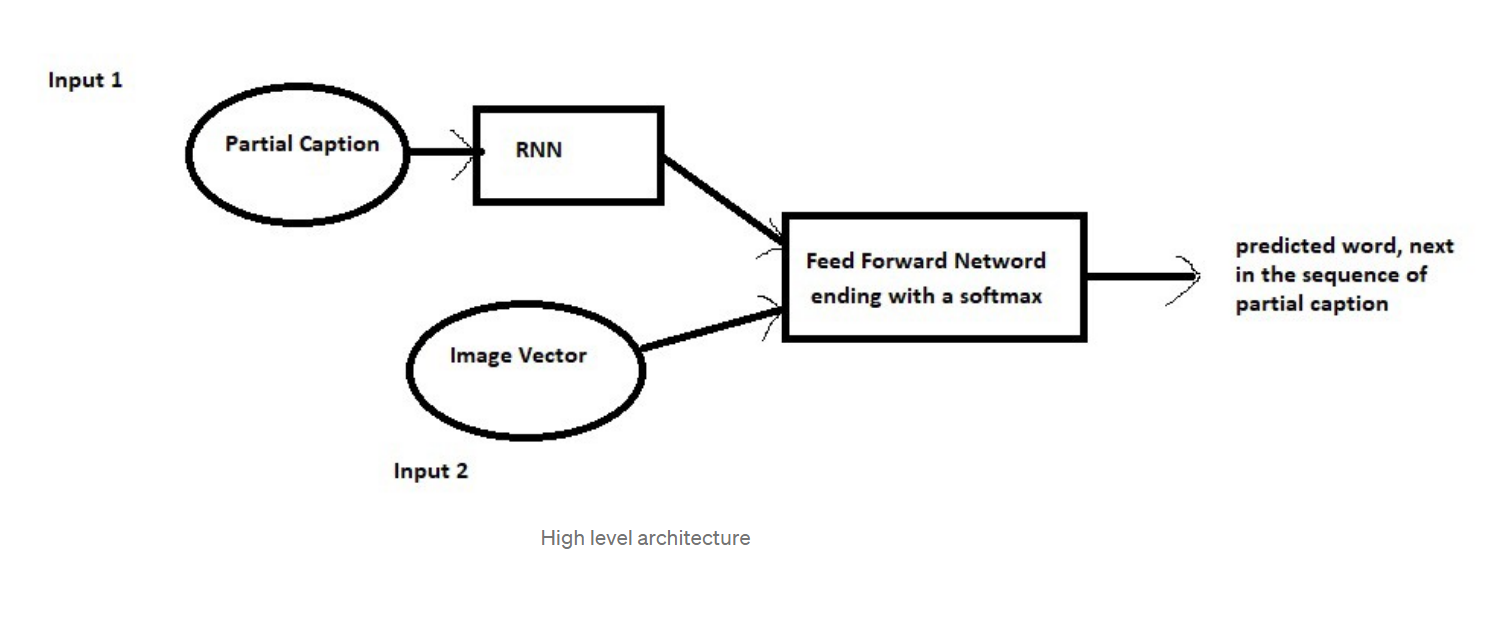

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

**Setting the 2nd layer as Embedded Matrix**

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

**Rough Model Layout**

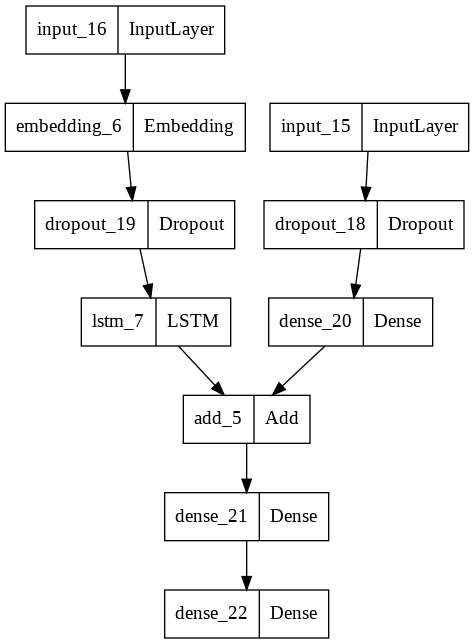

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_decay=LearningRateScheduler(scheduler)

**TRaining the Model**

In [ ]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_desc)//number_pics_per_batch

In [ ]:
#First part training
for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history1 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[lr_decay])

2333/2333 [==============================] - 344s 148ms/step - loss: 3.8648 - accuracy: 0.2162 - lr: 0.0010


In [ ]:
#Second part training

model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_batch = 6
steps = len(train_desc)//number_pics_per_batch


for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history2 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[lr_decay])

1166/1166 [==============================] - 193s 165ms/step - loss: 3.7389 - accuracy: 0.2295 - lr: 1.0000e-04


In [ ]:
# Third part training

model.optimizer.lr = 0.00005
epochs = 10
number_pics_per_bath = 6
steps = len(train_desc)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(train_desc, train_features, wordtoix, max_length, number_pics_per_batch)
    history3 = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[lr_decay])

1166/1166 [==============================] - 191s 164ms/step - loss: 3.7017 - accuracy: 0.2311 - lr: 5.0000e-05


We have got only 23% training accuracy over the 30 epochs .... Due to many factors such as very naive architecture , less amount of data etc

**Saving the Model**

In [ ]:
model.save('/content/drive/MyDrive/Image Captioning/Resources/best_model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Image Captioning/Resources/best_model.h5')

**Evaluating the Model**

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
def beam_search_predictions(image, beam_index):
    start = [wordtoix["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

**Generating the Caption over some Test Images**

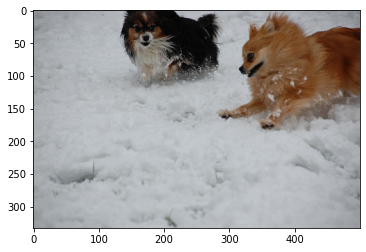

Greedy: two white and white dog is running in the snow
Beam: white and white dog is running in the snow


In [ ]:
pic = '2398605966_1d0c9e6a20.jpg'
images_path = '/content/drive/MyDrive/Image Captioning/Flicker8k_Dataset/'

encoded_image = test_features[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_image))
print("Beam:",beam_search_predictions(encoded_image,7))

In [ ]:
test_images_file = '/content/drive/MyDrive/Image Captioning/Flickr8k_text/Flickr_8k.testImages.txt'
test_image_file = open(test_images_file, 'r').read().strip().split('\n')

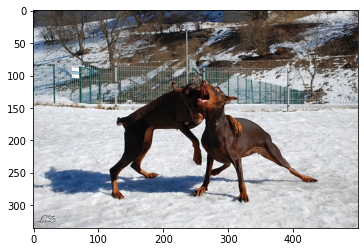

Greedy: two dogs are playing on the snow
Beam: two dogs play in the snow





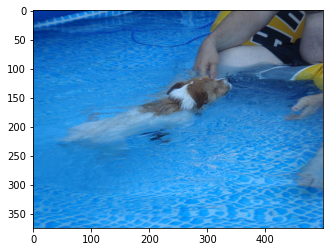

Greedy: two girl is pink in the water
Beam: little girl white in the water





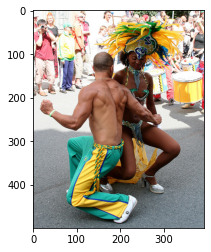

Greedy: two in in the white shirt and the street
Beam: man in black shirt and the street





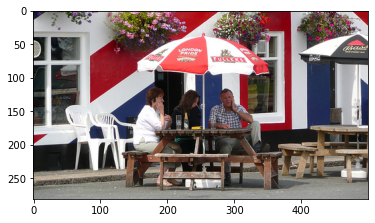

Greedy: man in black on the street of front of front of the background
Beam: group of people sit on front of bus





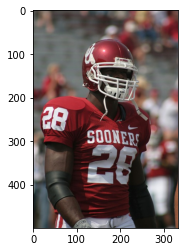

Greedy: football player in sooners
Beam: two football players in sooners





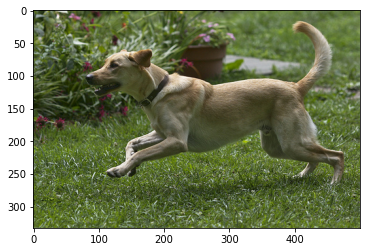

Greedy: brown dog is running through the grass
Beam: brown dog runs through the grass





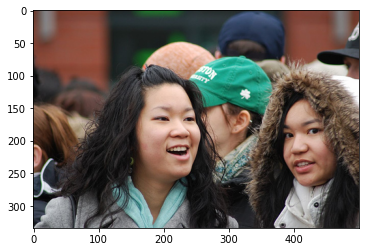

Greedy: woman in in red shirt and the camera
Beam: man in woman shirt and sunglasses





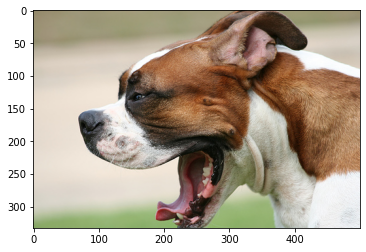

Greedy: dog dog is running on the sand
Beam: brown and white dog is running through the grass





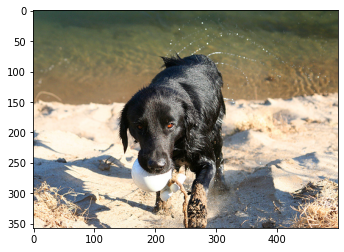

Greedy: black dog is running through the water
Beam: black dog runs through the water





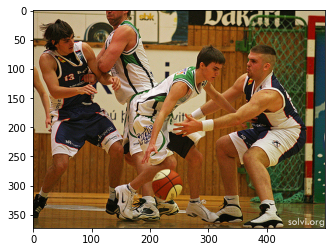

Greedy: basketball player player to the ball
Beam: basketball player player to ball





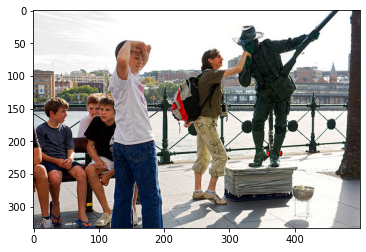

Greedy: man in red shirt and the street
Beam: man in black on the sidewalk





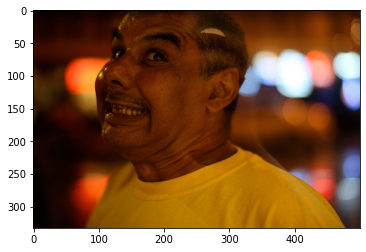

Greedy: man with woman shirt and wearing shirt is his head
Beam: man with woman shirt and the camera





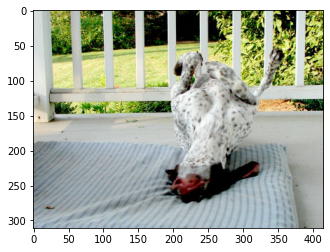

Greedy: dog dog and white dog is the grass
Beam: black and white dog is running on the grass





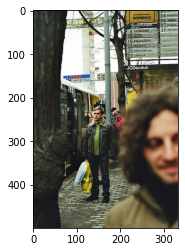

Greedy: man in woman jacket and standing of the sidewalk
Beam: man in woman jacket and the sidewalk





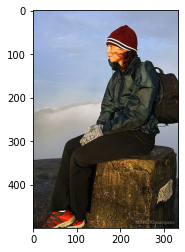

Greedy: man in red jacket is standing on the top
Beam: man wearing on the top of mountain





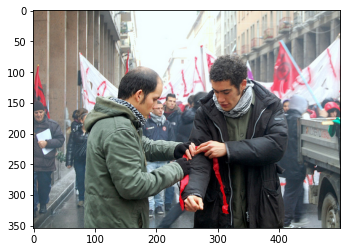

Greedy: man in woman shirt and the street
Beam: group of people are standing in front of store





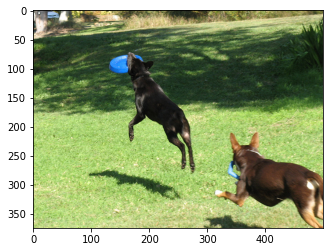

Greedy: black dog is running through the grass
Beam: black dog is running through the grass





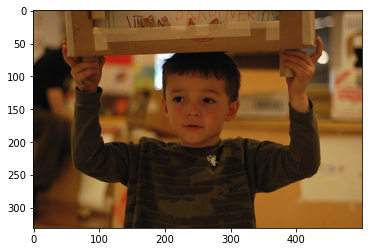

Greedy: man in red shirt is the street
Beam: man in red shirt is white violin





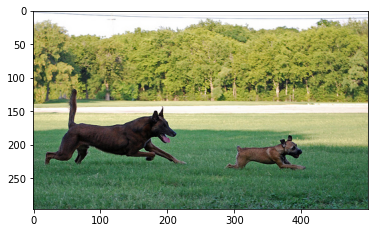

Greedy: two dogs are running in the grass
Beam: two dogs play in the grass





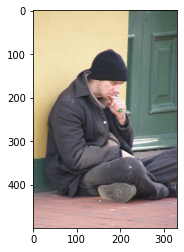

Greedy: man in woman shirt and the couch
Beam: man and woman shirt shirt on the couch





In [ ]:
for pic in test_image_file[:20]: 
  encoded_image = test_features[pic].reshape((1,2048))
  x=plt.imread(images_path+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(encoded_image))
  print("Beam:",beam_search_predictions(encoded_image,7))
  print("\n\n")

**Now Testing over the Image which is outside the distribution of FLICKR 8K**

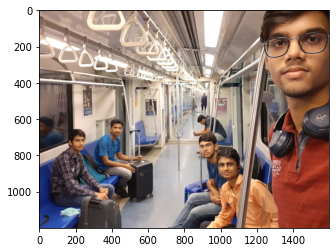

Greedy: man in woman shirt on the of the
Beam: group of people are sitting on front of bus


In [ ]:
path = '/content/drive/MyDrive/Image Captioning/27493fbf-505b-44f7-82a0-0e33c1de056f.jpg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,7))

PS : That is me (in blue T-shirt) with some of my college colleagues coming home after the covid outbreak in march 2020

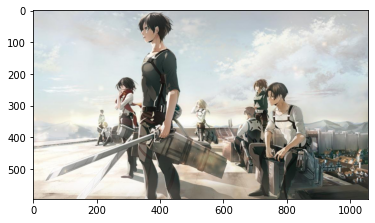

Greedy: man is woman shirt on the air
Beam: group of people riding on the air


In [ ]:
path = '/content/drive/MyDrive/Image Captioning/cropped-1920-1080-612522.jpg'

encoded_images = encode(path).reshape((1,2048))
x=plt.imread(path)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(encoded_images))
print("Beam:",beam_search_predictions(encoded_images,7))

**We can infer that Beam Search with beam index = 7 is producing more accurate results**

# **FUTURE WORKS**

1) Improving the results of the model

2) Trying out some new and more complex architecture such as Visual attention or Transformers

3) With improvement in resources trying out bigger dataset such as FLICKR 30K and MS COCO dataset can be used

4) Deploying the improved model over the net

**REFERENCES**

1) [ Tensorflow](https://www.tensorflow.org/tutorials/text/image_captioning)

2) [Research Paper](https://arxiv.org/pdf/1708.02043.pdf)

3) [ Article ](https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8)

In [ ]:
#THANK YOU
# RISHABH JHA
# S20190010150